Implementing a basic DE solver for the neutrino winds in terms of psi

Runge-Kutta method from Wikipedia:
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/25f03454fd25957cc63be11ec534efdce349c52f">
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/95bdbb2e3aa83735085c0aadd577162c69e4056a">
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/81398071e8f180ac143bfdf4598ff47bf79eb689">
I use $\psi$ in place of t, and {r,v} as y. I calculate separate k values for r and v to get y'={r',v'}

Questions/next steps:

Isentropic wind with ideal gas equation of state<br />
check small v0 - no turnover I can find<br />
check limits of gamma, maybe find v0 as a function of gamma<br />
calculate realistic a value - a~.1<br />
incorporate general EoS, not just gamma law<br>
things break around gamma=1.4

In [1]:
%matplotlib inline
%load_ext autoreload

In [ ]:
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import Adiabatic_wind_solver as aws
s=aws.solver(1,10)
s.makePlots(.001,.01,.0005,True,20,5);

In [ ]:
s.makePlots(.001,.01,.0005,False,10,5);

In [ ]:
v0avg=s.findV0(.001,.006,.0001)

In [ ]:
s.makePlot(v0avg,AV=True,xrange=10);

In [7]:
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import Adiabatic_wind_solver as aws

Searching gamma = 1.48000000000017
No sign change, decrementing bounds
Max iteration count exceeded at gamma = 1.48000000000017
No sign change above v0/cs = 1.925929944387236e-36


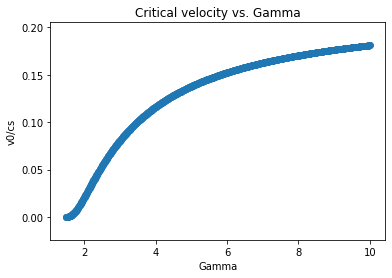

In [12]:
s=aws.solver(5/3,.1)
g=s.gammaSearch(a=.1,g0=10,dg=-.01,glim=1,lower=.01,upper=.9,itermax=100)

In [11]:
import sys
s1=aws.solver(5/3,.1)
s1.findV0(sys.float_info.min,.003,.0001,show=False)

0.0025060941696166995

In [ ]:
s1.makePlot(0.002506094169616699,AV=True,xrange=50)

In [ ]:
s2=aws.solver(1.675,.1)
plt.figure(1)
s2.makePlot(2.76218930e-03,AV=True)


In [ ]:
plt.figure(2)
s2.makePlot(2.76218930e-03,AV=False)

In [ ]:

print(g[:,0],g[:,1])
plt.figure(1)
#plt.xscale("log")
#plt.ylim((0,1e-2))
plt.scatter(g[:,0],g[:,1])
print(0.005075313376262784/0.005075325407087801)
print(4.149019718170166e-06/4.1489973664283755e-06)
#np.log(1.000001)

In [ ]:
g=np.array([[1.00000000e+000,5.07531939e-003],
 [1.00250000e+000,4.62911165e-003],
 [1.00500000e+000,4.20731798e-003],
 [1.00750000e+000,3.81006171e-003],
 [1.01000000e+000,3.43697821e-003],
 [1.01250000e+000,3.08769045e-003],
 [1.01500000e+000,2.76168418e-003],
 [1.01750000e+000,2.45847751e-003],
 [1.02000000e+000,2.17755702e-003],
 [1.02250000e+000,1.91831820e-003],
 [1.02500000e+000,1.68010795e-003],
 [1.02750000e+000,1.46168831e-003],
 [1.03000000e+000,1.26368850e-003],
 [1.03250000e+000,1.08452495e-003],
 [1.03500000e+000,9.23378885e-004],
 [1.03750000e+000,7.79387704e-004],
 [1.04000000e+000,6.51646955e-004],
 [1.04250000e+000,5.39213916e-004],
 [1.04500000e+000,4.41111065e-004],
 [1.04750000e+000,3.56331702e-004],
 [1.05000000e+000,2.83816273e-004],
 [1.05250000e+000,2.22537182e-004],
 [1.05500000e+000,1.71461957e-004],
 [1.05750000e+000,1.29535273e-004],
 [1.06000000e+000,9.56936404e-005],
 [1.06250000e+000,6.89108782e-005],
 [1.06500000e+000,4.81852982e-005],
 [1.06750000e+000,3.25580444e-005],
 [1.07000000e+000,2.11319325e-005],
 [1.07250000e+000,1.30738579e-005],
 [1.07500000e+000,7.62642547e-006],
 [1.07750000e+000,4.14900854e-006],
 [1.08000000e+000,2.06491537e-006],
 [1.08250000e+000,9.16410238e-007],
 [1.08500000e+000,3.49223614e-007],
 [1.08750000e+000,1.07673928e-007],
 [1.09000000e+000,2.42907554e-008],
 [1.09250000e+000,3.31923366e-009],
 [1.09500000e+000,2.00117938e-010],
 [1.09750000e+000,1.04773790e-012]])

In [ ]:
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import Adiabatic_wind_solver as aws
s2=aws.solver(1.07250000e+00,10)
s2.makePlot(1.30738831e-05,AV=False,xrange=20)

In [ ]:
n=0
def er():
    raise NoSignChange
try:
    n=n+1
    er()
    n=n+1
except NoSignChange:
    print("no sign change")
print(n)

In [ ]:
import csv
with open('gamma_data.csv', mode='w') as dfile:
    datawriter = csv.writer(dfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(len(g)):
        datawriter.writerow([g[i,0],g[i,1]])
dfile.close()
